In [1]:
import numpy as np
import os
from pixell import enmap, curvedsky as cs, enplot, reproject, utils
from solenspipe.utility import w_n, smooth_cls
from solenspipe import get_qfunc
from falafel import utils as futils, qe
import pytempura
import argparse
from orphics import maps, stats, mpi, io
import utils as autils
from mnms import utils as mutils
import pickle
import pysm3
import pysm3.units as u
from mnms import utils as mutils
# import os
# os.chdir('/home/ia404/gitreps/dustbias/mbatch')
# import utils as autils
# import numpy as np
import healpy as hp
# from falafel import utils as futils, qe
# from pixell import curvedsky as cs, enmap, enplot, reproject, utils as putils
import matplotlib.pyplot as plt
# import argparse
# import pytempura
from sofind import DataModel
from solenspipe.utility import w_n #, smooth_cls
# from solenspipe import get_qfunc
# from orphics import maps

from matplotlib.lines import Line2D
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import to_hex

from matplotlib import rcParams
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

# Función para obtener colores discretos de un colormap
def get_discrete_colors(cmap_name, num_colors):
    cmap = cm.get_cmap(cmap_name, num_colors)
    return [to_hex(cmap(i)) for i in range(num_colors)]

--------------------------------------------------------------------------
detected:

  Local host:            cpu-r-46
  Device name:           mlx5_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4129

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   cpu-r-46
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
args = argparse.Namespace()

args.output_dir = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/local_dustbias/'
args.dust_freq = 90
args.skyfrac='GAL060'
args.mlmax=4000
args.mask_subproduct='lensing_masks'
args.mask_type='dr6v4_lensing_20240919'
args.apodfact='_d2_apo3deg'
args.daynight='night'
args.config_name='act_dr6v4'
args.width_ra=15
args.width_dec=10
args.hpmask_fname = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/Planck/HFI_Mask_GalPlane-apo5_2048_R2.00.fits'
args.nside=2048
args.amplitudes_path = '/home/ia404/gitreps/dustbias/mbatch/local_dustbias/amplitudes.pkl'
args.tilt_gauss = -0.8

dm = DataModel.from_config(args.config_name)

In [3]:
masks_pixell = {}
w2_pixell = {}
for fsky in autils.FSKYS:
    masks_pixell[fsky] = dm.read_mask(mask_fn = f'{args.mask_type}_{args.daynight}_enhanced_mask_{fsky.split("GAL0")[1]}_d2_apo3deg.fits', subproduct=args.mask_subproduct)
    w2_pixell[fsky] = w_n(masks_pixell[fsky],2)

In [4]:
args.shape, args.wcs = masks_pixell[args.skyfrac].shape, masks_pixell[args.skyfrac].wcs

In [5]:
data_maps = {}

for dust_type in autils.DUST_TYPES:
    data_maps[dust_type] = enmap.read_map(args.output_dir + f'stage_generate_dustng_maps/{autils.get_scaled_map_name(dust_type, sim_id=1000, fsky=args.skyfrac, freq=args.dust_freq)}')

In [6]:
cl_2pts = {}

for dust_type in autils.DUST_TYPES:
    
    dust_alm = cs.map2alm(data_maps[dust_type] * masks_pixell[args.skyfrac], lmax=args.mlmax)
    cl_2pts[dust_type] = cs.alm2cl(dust_alm) / w2_pixell[args.skyfrac]

In [7]:
ell = np.arange(args.mlmax+1)
lfac = ell * (ell + 1) / (2 * np.pi)

# Generar colores discretos
num_colors = len(autils.DUST_TYPES)  # Número total de combinaciones de freq, pysm_model y mask
discrete_colors = get_discrete_colors('viridis', num_colors)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


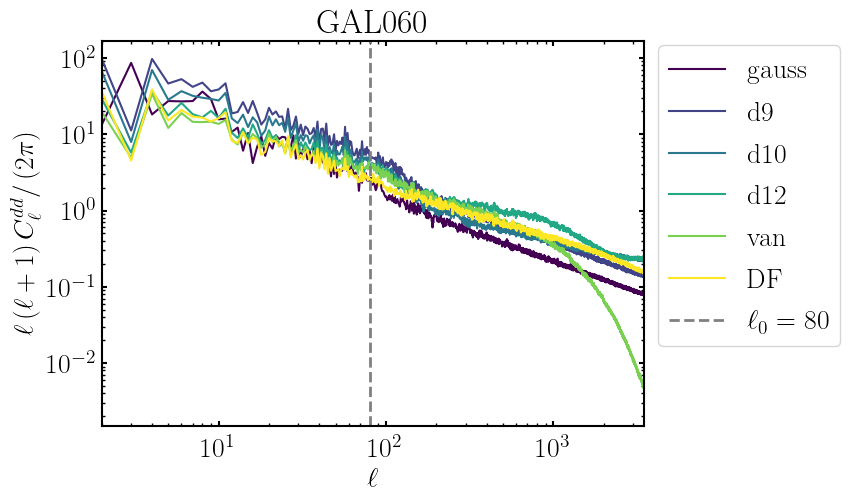

In [8]:
fig, ax = plt.subplots(1, figsize=(7,5))#, sharex=True, sharey=True)


for i,dust_type in enumerate(autils.DUST_TYPES):
    ax.loglog(ell[:-25], (lfac*cl_2pts[dust_type])[:-25], color=discrete_colors[i], label=dust_type)
    
ax.axvline(80, color='gray', linestyle='dashed', lw=2, label=r'$\ell_0 = 80$')
ax.set_xlim(2, 3500)

legend = ax.legend(bbox_to_anchor=(1, 1.025), loc = 'upper left') # (1, 1.025)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell\left(\ell+1\right) C_\ell^{dd} / \left(2\pi\right)$')
ax.set_title(args.skyfrac)
#fig.savefig('./Figures/2pt_comparison.png', bbox_inches='tight')
plt.show()

In [9]:
hp_masks = {}
w2_hpmasks = {}
for i, fsky in enumerate(autils.FSKYS):
    hp_masks[fsky] =  hp.read_map(args.hpmask_fname, field=2+i)
    w2_hpmasks[fsky] = np.mean(hp_masks[fsky]**2)

In [50]:
hp_car_masks = {}
for a in hp_masks.keys():
    hp_car_masks[a] = reproject.healpix2map(hp_masks[a], masks_pixell[a].shape, masks_pixell[a].wcs, lmax = args.mlmax, rot="gal,cel")   

In [10]:
with open(args.amplitudes_path, 'rb') as file:
    amplitudes = pickle.load(file)

In [11]:
sky_hp_maps = {}
for dust_type in ['d9', 'd10', 'd12']:

    print(dust_type)
    sky_dust = pysm3.Sky(nside=args.nside, preset_strings=[dust_type])
    map_freqGHz = sky_dust.get_emission(args.dust_freq * u.GHz)
    sky_hp_maps[dust_type] = map_freqGHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(args.dust_freq*u.GHz))[0]

d9
d10
d12


In [12]:
sky_hp_maps['DF'] = hp.read_map(autils.FG_PATH_DICT[f'dust_DF_{args.dust_freq:.1f}'] + '.fits', field=0)
sky_hp_maps['van'] = hp.read_map(autils.FG_PATH_DICT[f'dust_van_{args.dust_freq:.1f}'] + '.fits', field=0)

In [40]:
sky_car_maps = {}
for dust_type in ['d9', 'd10', 'd12', 'DF','van']:
    
    sky_car_maps[f'{dust_type}_{args.skyfrac}'] = reproject.healpix2map(sky_hp_maps[f'{dust_type}'], masks_pixell[args.skyfrac].shape, masks_pixell[args.skyfrac].wcs, lmax = args.mlmax, rot="gal,cel")

In [32]:
sky_car_maps.keys()

dict_keys(['d9_GAL060', 'd10_GAL060', 'd12_GAL060', 'DF_GAL060', 'van_GAL060'])

In [15]:
autils.power_law(ell, amplitude=amplitudes['90.0_d9_GAL060'], tilt=args.tilt_gauss)[80]

55.2976599236941

In [19]:
amplitudes['90.0_d9_GAL060']

55.29821289960211

/home/ia404/gitreps/dustbias/mbatch/local_dustbias/utils.py:48: RuntimeWarning: divide by zero encountered in divide
  return dl * 2 * np.pi / l / (l + 1)


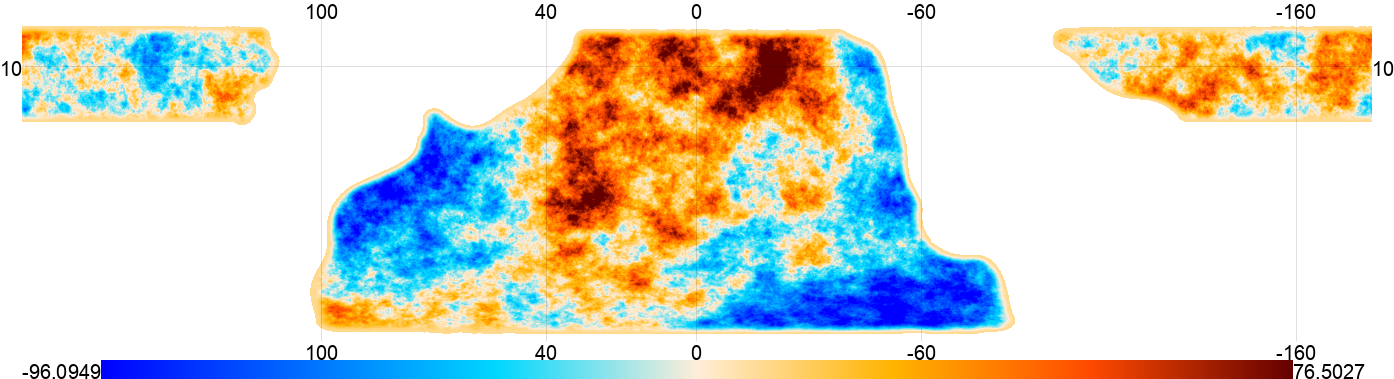

/home/ia404/gitreps/dustbias/mbatch/local_dustbias/utils.py:48: RuntimeWarning: divide by zero encountered in divide
  return dl * 2 * np.pi / l / (l + 1)


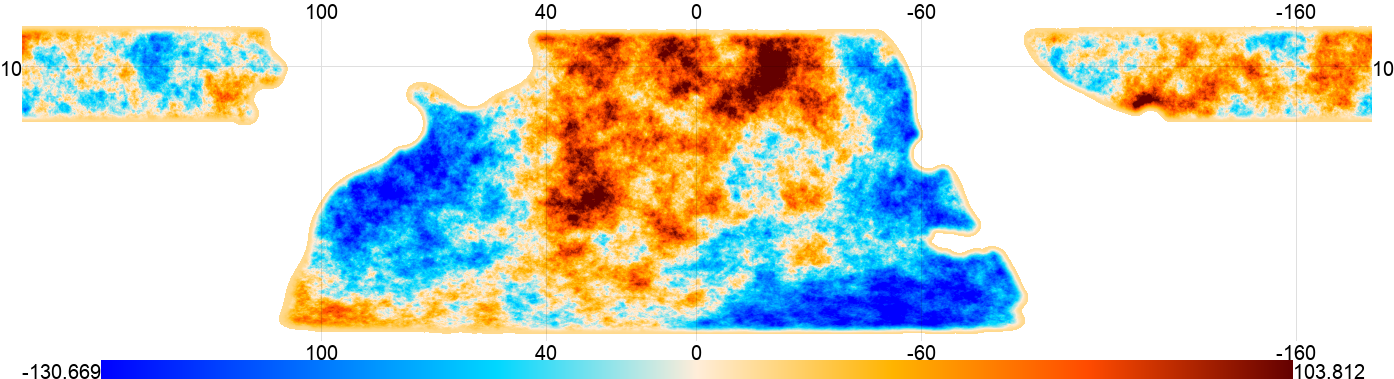

/home/ia404/gitreps/dustbias/mbatch/local_dustbias/utils.py:48: RuntimeWarning: divide by zero encountered in divide
  return dl * 2 * np.pi / l / (l + 1)


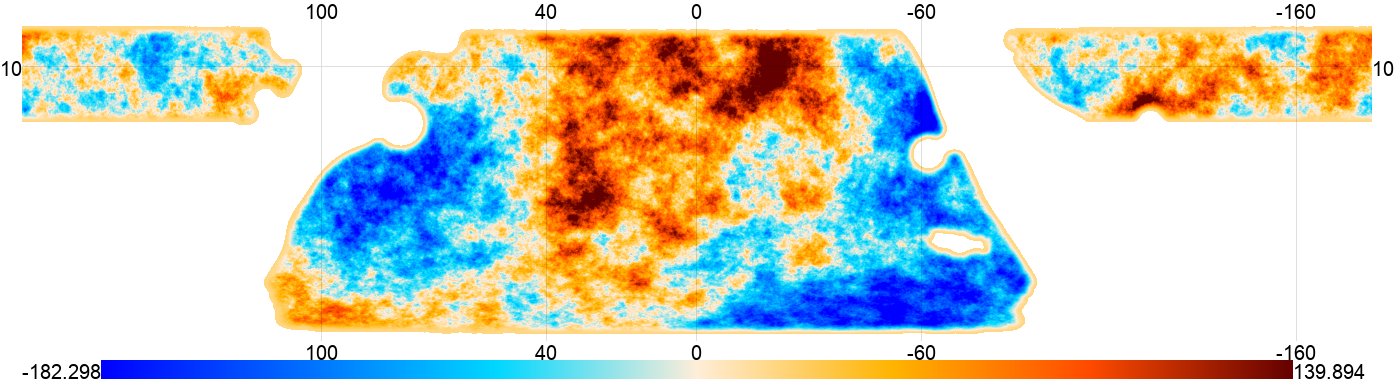

In [22]:
# only for gauss here

dust_hp_cls = {}
rescaled_sky_hp_maps = {}
rescaled_sky_car_maps = {}

for fsky in autils.FSKYS:
    
    amplitude_gauss = amplitudes[f'{args.dust_freq:.1f}_d9_{fsky}']
    dust_cl_generate = autils.dl_to_cl(autils.power_law(ell, amplitude=amplitude_gauss, tilt=args.tilt_gauss), ell)
    dust_cl_generate[0] = 0
    np.random.seed(100)
    dust_hp_cls[f'gauss_{fsky}'] = dust_cl_generate # randomly generated gaussian dust map
    sky_hp_maps[f'gauss_{fsky}'] = hp.sphtfunc.synfast(dust_cl_generate, nside=args.nside, alm=False) # randomly generated gaussian dust map
    rescaled_sky_hp_maps[f'gauss_{fsky}'] = sky_hp_maps[f'gauss_{fsky}']
    
    rescaled_sky_car_maps[f'gauss_{fsky}'] = reproject.healpix2map(rescaled_sky_hp_maps[f'gauss_{fsky}'], masks_pixell[fsky].shape, masks_pixell[fsky].wcs, lmax = args.mlmax, rot="gal,cel")
    mutils.eplot(rescaled_sky_car_maps[f'gauss_{fsky}'] * masks_pixell[fsky], downgrade=16, colorbar=True, ticks=100, mask =0, show=True)

In [23]:
amplitudes['90.0_d9_GAL060'] / ( 80 * (80+1) / 2 / np.pi)

0.05361866030926985

In [24]:
dust_hp_cls['gauss_GAL060'][80]

0.05361812412869879

In [46]:
factor = {}
rescaled_anafast_cl = {}
for dust_type in ['d9', 'd10', 'd12', 'van', 'DF']:
    for fsky in autils.FSKYS:
        anafast_cl = hp.anafast(sky_hp_maps[dust_type] * hp_masks[fsky], lmax=args.mlmax)
        dust_hp_cls[f'{dust_type}_{fsky}'] = anafast_cl / w2_hpmasks[fsky]
        factor[f'{dust_type}_{fsky}'] = (dust_hp_cls[f'{dust_type}_{fsky}'] / dust_hp_cls[f'gauss_{fsky}'])[80]
        rescaled_sky_hp_maps[f'{dust_type}_{fsky}'] = sky_hp_maps[dust_type] / np.sqrt(factor[f'{dust_type}_{fsky}'])
        
        rescaled_anafast_cl[f'{dust_type}_{fsky}'] = hp.anafast(rescaled_sky_hp_maps[f'{dust_type}_{fsky}'] * hp_masks[fsky], lmax=args.mlmax) / w2_hpmasks[fsky]
        rescaled_sky_car_maps[f'{dust_type}_{fsky}'] = reproject.healpix2map(rescaled_sky_hp_maps[f'{dust_type}_{fsky}'], masks_pixell[fsky].shape, masks_pixell[fsky].wcs, lmax = args.mlmax, rot="gal,cel")   

/tmp/ipykernel_141984/3215016402.py:7: RuntimeWarning: divide by zero encountered in divide
  factor[f'{dust_type}_{fsky}'] = (dust_hp_cls[f'{dust_type}_{fsky}'] / dust_hp_cls[f'gauss_{fsky}'])[80]
/tmp/ipykernel_141984/3215016402.py:7: RuntimeWarning: divide by zero encountered in divide
  factor[f'{dust_type}_{fsky}'] = (dust_hp_cls[f'{dust_type}_{fsky}'] / dust_hp_cls[f'gauss_{fsky}'])[80]
/tmp/ipykernel_141984/3215016402.py:7: RuntimeWarning: divide by zero encountered in divide
  factor[f'{dust_type}_{fsky}'] = (dust_hp_cls[f'{dust_type}_{fsky}'] / dust_hp_cls[f'gauss_{fsky}'])[80]
/tmp/ipykernel_141984/3215016402.py:7: RuntimeWarning: divide by zero encountered in divide
  factor[f'{dust_type}_{fsky}'] = (dust_hp_cls[f'{dust_type}_{fsky}'] / dust_hp_cls[f'gauss_{fsky}'])[80]
/tmp/ipykernel_141984/3215016402.py:7: RuntimeWarning: divide by zero encountered in divide
  factor[f'{dust_type}_{fsky}'] = (dust_hp_cls[f'{dust_type}_{fsky}'] / dust_hp_cls[f'gauss_{fsky}'])[80]
/tmp/ipyke

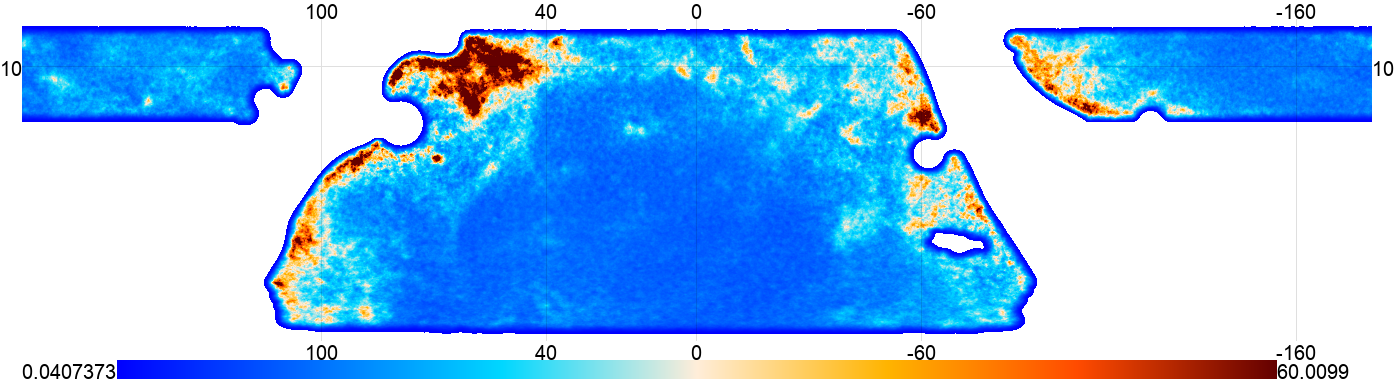

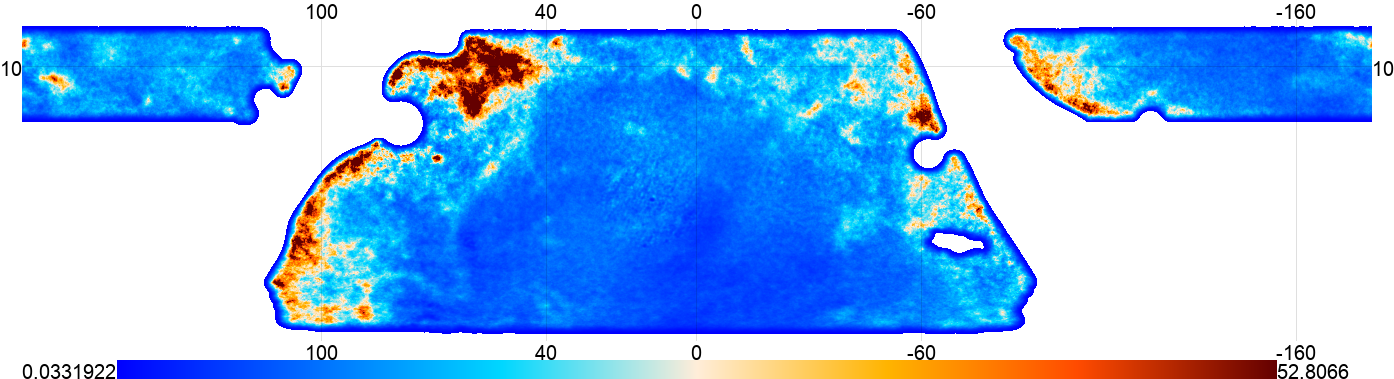

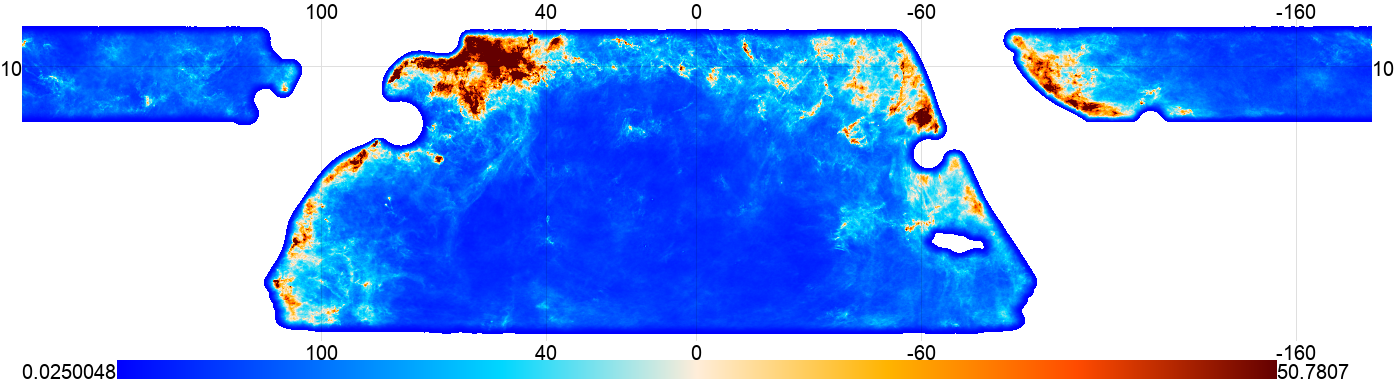

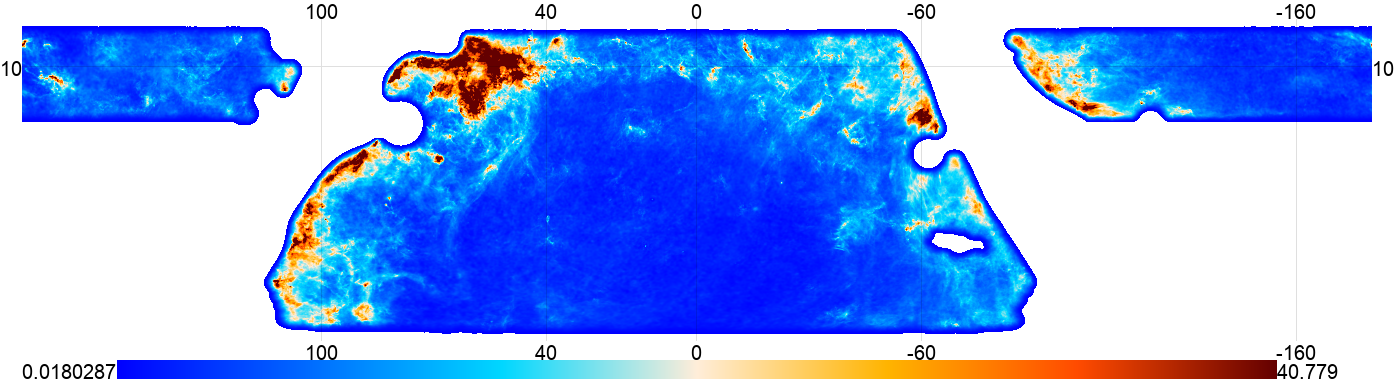

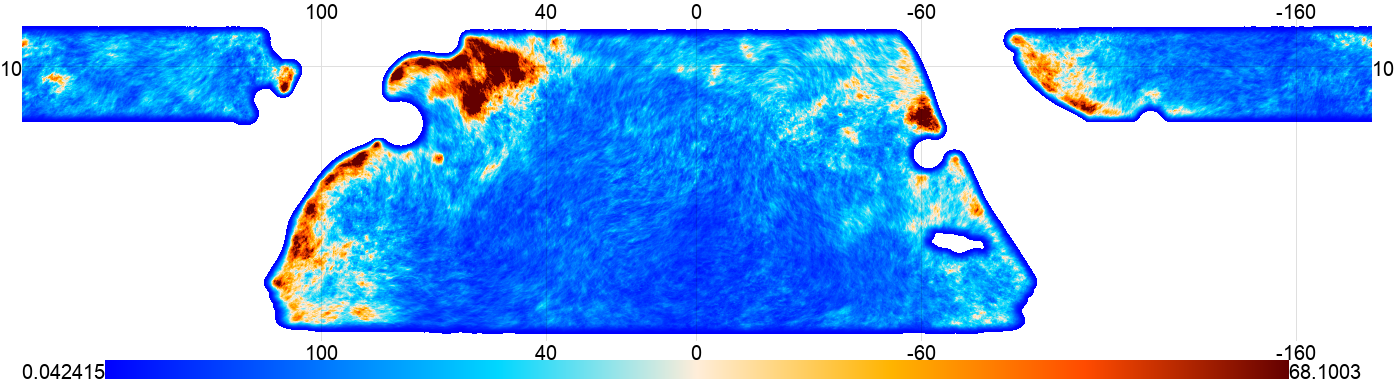

In [26]:
for dust_type in ['d9', 'd10', 'd12', 'van', 'DF']:
    mutils.eplot(sky_car_maps[f'{dust_type}'] * masks_pixell[fsky], downgrade=16, colorbar=True, ticks=100, mask =0, show=True)

In [53]:
cl_2pts_rescaled = {}
cl_2pts_rescaled_hpmask = {}
cl_2pts_raw = {}

for dust_type in ['d9', 'd10', 'd12', 'van', 'DF']: 
        
    dust_alm = cs.map2alm(rescaled_sky_car_maps[f'{dust_type}_{args.skyfrac}'] * masks_pixell[args.skyfrac], lmax=args.mlmax)
    cl_2pts_rescaled[dust_type] = cs.alm2cl(dust_alm) / w2_pixell[args.skyfrac]
    
    dust_alm = cs.map2alm(sky_car_maps[f'{dust_type}_{args.skyfrac}'] * masks_pixell[args.skyfrac], lmax=args.mlmax)
    cl_2pts_raw[dust_type] = cs.alm2cl(dust_alm) / w2_pixell[args.skyfrac]
    
    dust_alm = cs.map2alm(sky_car_maps[f'{dust_type}_{args.skyfrac}'] * hp_car_masks[args.skyfrac], lmax=args.mlmax)
    cl_2pts_rescaled_hpmask[dust_type] = cs.alm2cl(dust_alm) / w_n(hp_car_masks[args.skyfrac],2) # w2_pixell[args.skyfrac]
    

In [42]:
cl_2pts_rescaled[dust_type][80]

0.0007186911710661192

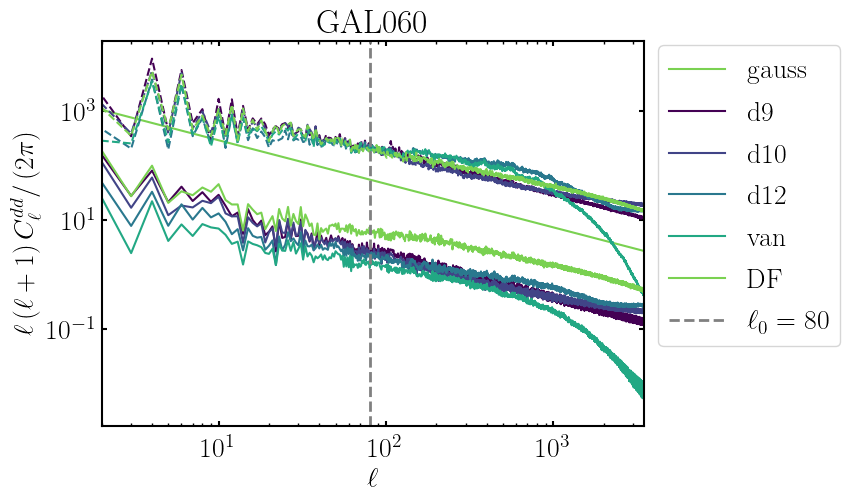

In [56]:
fig, ax = plt.subplots(1, figsize=(7,5))#, sharex=True, sharey=True)

ax.loglog(ell[:-25], (lfac*dust_hp_cls[f'gauss_{args.skyfrac}'])[:-25], color=discrete_colors[i], label='gauss')
for i,dust_type in enumerate(['d9', 'd10', 'd12', 'van', 'DF']):
    #ax.loglog(ell[:-25], (lfac*cl_2pts_rescaled[dust_type])[:-25], color=discrete_colors[i], label=dust_type)
    ax.loglog(ell[:-25], (lfac*rescaled_anafast_cl[f'{dust_type}_{fsky}'])[:-25], color=discrete_colors[i], linestyle = 'dashed') #  label=dust_type)
    ax.loglog(ell[:-25], (lfac*cl_2pts_rescaled_hpmask[dust_type])[:-25], color=discrete_colors[i], label=dust_type)
ax.axvline(80, color='gray', linestyle='dashed', lw=2, label=r'$\ell_0 = 80$')
ax.set_xlim(2, 3500)

legend = ax.legend(bbox_to_anchor=(1, 1.025), loc = 'upper left') # (1, 1.025)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell\left(\ell+1\right) C_\ell^{dd} / \left(2\pi\right)$')
ax.set_title(args.skyfrac)
#fig.savefig('./Figures/2pt_comparison.png', bbox_inches='tight')
plt.show()

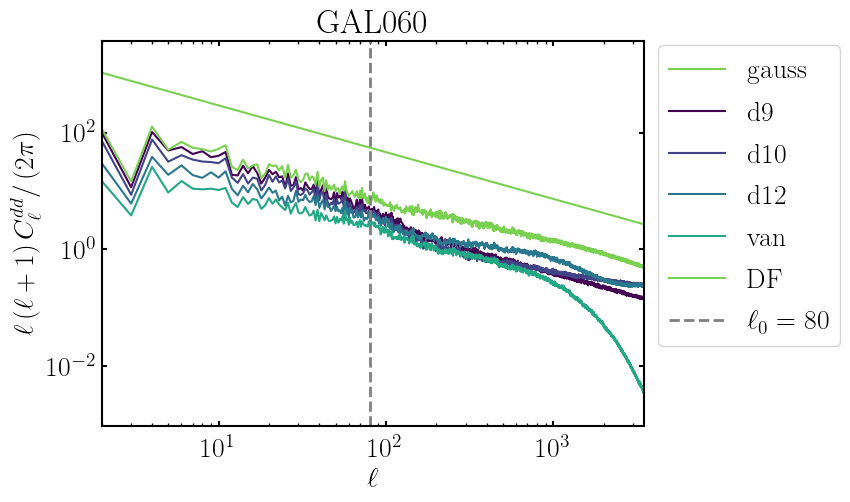

In [44]:
fig, ax = plt.subplots(1, figsize=(7,5))#, sharex=True, sharey=True)

ax.loglog(ell[:-25], (lfac*dust_hp_cls[f'gauss_{args.skyfrac}'])[:-25], color=discrete_colors[i], label='gauss')
for i,dust_type in enumerate(['d9', 'd10', 'd12', 'van', 'DF']):
    ax.loglog(ell[:-25], (lfac*cl_2pts_raw[dust_type])[:-25], color=discrete_colors[i], label=dust_type)
    
ax.axvline(80, color='gray', linestyle='dashed', lw=2, label=r'$\ell_0 = 80$')
ax.set_xlim(2, 3500)

legend = ax.legend(bbox_to_anchor=(1, 1.025), loc = 'upper left') # (1, 1.025)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell\left(\ell+1\right) C_\ell^{dd} / \left(2\pi\right)$')
ax.set_title(args.skyfrac)
#fig.savefig('./Figures/2pt_comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
rescaled_sky_car_maps[f'{dust_type}_{fsky}']

In [53]:
for dust_type in autils.DUST_TYPES:
    for fsky in autils.FSKYS:
        no_rescaled_sky_car_map = reproject.healpix2map(sky_hp_maps[dust_type], masks_pixell[fsky].shape, masks_pixell[fsky].wcs, lmax = args.mlmax, rot="gal,cel")
        rescaled_sky_car_map = reproject.healpix2map(rescaled_sky_hp_maps[f'{dust_type}_{fsky}'], masks_pixell[fsky].shape, masks_pixell[fsky].wcs, lmax = args.mlmax, rot="gal,cel")
        rescaled_sky_car_maps_mask = rescaled_sky_car_map * masks_pixell[fsky]
        # enmap.write_map(output_path(autils.get_scaled_map_name(dust_type, sim_id=1000, fsky=fsky, freq=args.dust_freq)), rescaled_sky_car_maps_mask)

KeyError: 'gauss'